# NLP and Sentiment Analysis based Trading Strategy; Pre-trained FinBert



In [1]:
import pkg_resources
import pip
installedPackages = {pkg.key for pkg in pkg_resources.working_set}
required = {'nltk', 'spacy', 'textblob', 'backtrader'}
missing = required - installedPackages
if missing:
    !pip install nltk==3.4
    !pip install textblob==0.15.3
    !pip install -U SpaCy==2.2.0
    !python -m spacy download en_core_web_lg
    !pip install backtrader==1.9.74.123    

In [2]:
#NLP libraries
from textblob import TextBlob
import spacy
import nltk
import warnings
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
import csv
import pandas as pd

#Run the command python -m spacy download en_core_web_sm to download this
#https://spacy.io/models
import en_core_web_lg
nlp = en_core_web_lg.load()

#Libraries for processing the news headlines
from lxml import etree
import json
from io import StringIO
from os import listdir
from os.path import isfile, join
from pandas.tseries.offsets import BDay
from scipy.stats.mstats import winsorize
from copy import copy

# Libraries for Classification for modeling the sentiments
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Keras package for the deep learning model for the sentiment prediction. 
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, Dropout, Activation
from keras.layers.embeddings import Embedding

# Load libraries
import statsmodels.api as sm
import seaborn as sns
import pandas as pd
import numpy as np
import datetime
from datetime import date
import matplotlib.pyplot as plt
import yfinance as yf

#Additional Libraries 
import json  
import zipfile
import os.path
import sys


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\tatsa\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
Using TensorFlow backend.


In [2]:
#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
tickers = ['AAPL','MSFT','AMZN','GOOG','FB','WMT','JPM','TSLA','NFLX','ADBE']
start = '2010-01-01'
end = '2018-12-31'
df_ticker_return = pd.DataFrame()
for ticker in tickers:    
    ticker_yf = yf.Ticker(ticker)
    if df_ticker_return.empty:
        df_ticker_return = ticker_yf.history(start = start, end = end)
        df_ticker_return['ticker']= ticker 
    else:
        data_temp = ticker_yf.history(start = start, end = end)
        data_temp['ticker']= ticker 
        df_ticker_return = df_ticker_return.append(data_temp)
df_ticker_return.to_csv(r'Data\Step2.2_ReturnData.csv')

Let us look at the details of the data

In [4]:
df_ticker_return.head(2)

,Open,High,Low,Close,Volume,Dividends,Stock Splits,ticker
Date,,,,,,,,
2010-01-04,26.40,26.53,26.27,26.47,123432400,0.0,0.0,AAPL
2010-01-05,26.54,26.66,26.37,26.51,150476200,0.0,0.0,AAPL


In [5]:
z = zipfile.ZipFile("Data/Raw Headline Data.zip", "r")
testFile=z.namelist()[10]
fileData= z.open(testFile).read() 
fileDataSample = json.loads(fileData)['content'][1:500]  
fileDataSample

'li class="n-box-item date-title" data-end="1305172799" data-start="1305086400" data-txt="Tuesday, December 17, 2019">Wednesday, May 11, 2011</li><li class="n-box-item sa-box-item" data-id="76179" data-ts="1305149244"><div class="media media-overflow-fix"><div class="media-left"><a class="box-ticker" href="/symbol/CSCO" target="_blank">CSCO</a></div><div class="media-body"><h4 class="media-heading"><a href="/news/76179" sasource="on_the_move_news_fidelity" target="_blank">Cisco (NASDAQ:CSCO): Pr'

In [6]:
#This function performs the json parsing given the 
def jsonParser(json_data): 
    xml_data = json_data['content']
            
    tree = etree.parse(StringIO(xml_data), parser=etree.HTMLParser())

    headlines = tree.xpath("//h4[contains(@class, 'media-heading')]/a/text()")
    assert len(headlines) == json_data['count']

    main_tickers = list(map(lambda x: x.replace('/symbol/', ''), tree.xpath("//div[contains(@class, 'media-left')]//a/@href")))
    assert len(main_tickers) == json_data['count']
    final_headlines = [''.join(f.xpath('.//text()')) for f in tree.xpath("//div[contains(@class, 'media-body')]/ul/li[1]")]
    if len(final_headlines) == 0:
        final_headlines = [''.join(f.xpath('.//text()')) for f in tree.xpath("//div[contains(@class, 'media-body')]")]
        final_headlines = [f.replace(h, '').split('\xa0')[0].strip() for f,h in zip (final_headlines, headlines)]
    return main_tickers, final_headlines

In [8]:
data = None 
data_df_news = []
ret = []
ret_f = []
with zipfile.ZipFile("Data/Raw Headline Data.zip", "r") as z:
    for filename in z.namelist(): 
        #print(filename)
        try:               
            #print('Running {}'.format(filename))
            with z.open(filename) as f:  
                data = f.read()  
                json_data = json.loads(data)      
            if json_data.get('count', 0)> 10:
                #Step 1: Parse the News Jsons 
                main_tickers, final_headlines = jsonParser(json_data) 
                if len(final_headlines) != json_data['count']:
                    continue
                #Step 2: Prepare Future and Event Return and assign Future and Event return for each ticker. 
                file_date = filename.split('/')[-1].replace('.json', '')
                file_date = date(int(file_date[:4]), int(file_date[5:7]), int(file_date[8:]))
               #Step 3: Merge all the data in a data frame
                df_dict = {'ticker': main_tickers,
                           'headline': final_headlines,            
                           'date': [file_date] * len(main_tickers)
                           }
                df_f = pd.DataFrame(df_dict)            
                data_df_news.append(df_f)            
        except:
            pass  

In [9]:
data_df_news=pd.concat(data_df_news)
data_df_news.head(2)

,ticker,headline,date
0,DVA,Davita (NYSE:DVA): EPS of $0.96 beats by $0.01...,2011-05-02
1,CGNX,Cognex (NASDAQ:CGNX): EPS of $0.32 beats by $0...,2011-05-02


In [10]:
#Computing the return
df_ticker_return['ret_curr'] = df_ticker_return['Close'].pct_change()
#Computing the event return
df_ticker_return['eventRet'] = df_ticker_return['ret_curr'] + df_ticker_return['ret_curr'].shift(-1) + df_ticker_return['ret_curr'].shift(1)
df_ticker_return.reset_index(level=0, inplace=True)
df_ticker_return['date'] = pd.to_datetime(df_ticker_return['Date']).apply(lambda x: x.date())

In [11]:
combinedDataFrame = pd.merge(data_df_news, df_ticker_return, how='left', left_on=['date','ticker'], right_on=['date','ticker'])
combinedDataFrame = combinedDataFrame[combinedDataFrame['ticker'].isin(tickers)]
data_df = combinedDataFrame[['ticker','headline','date','eventRet','Close']]
data_df = data_df.dropna()

In [12]:
data_df.head(2)

,ticker,headline,date,eventRet,Close
5,AMZN,Whole Foods (WFMI) -5.2% following a downgrade...,2011-05-02,0.017650,201.19
11,NFLX,Netflix (NFLX +1.1%) shares post early gains a...,2011-05-02,-0.013003,33.88


In [14]:
data_df = pd.read_csv(r'Data\Step3_NewsAndReturnData.csv', sep='|')
data_df = data_df.dropna()

In [15]:
print(data_df.shape, data_df.ticker.unique().shape)

(2759, 5) (10,)



# Evaluate Models for Sentiment Analysis

In [16]:
text1 = "Bayer (OTCPK:BAYRY) started the week up 3.5% to €74/share in Frankfurt, touching their \
highest level in 14 months, after the U.S. government said a $25M glyphosate decision against the \
company should be reversed."

In [17]:
TextBlob(text1).sentiment.polarity

0.5

In [18]:
data_df['sentiment_textblob'] = [TextBlob(s).sentiment.polarity for s in data_df['headline']] 

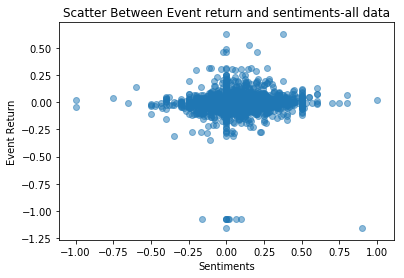

In [19]:
plt.scatter(data_df['sentiment_textblob'],data_df['eventRet'], alpha=0.5)
plt.title('Scatter Between Event return and sentiments-all data')
plt.ylabel('Event Return')
plt.xlabel('Sentiments')
plt.show()

In [20]:
corrlation = data_df['eventRet'].corr(data_df['sentiment_textblob'])
print(corrlation)

0.042749340813834254


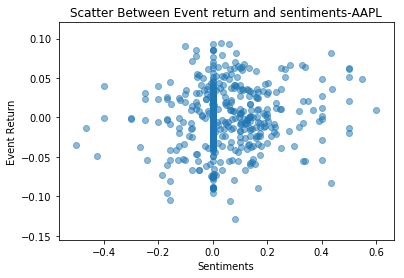

In [21]:
data_df_stock  = data_df[data_df['ticker'] == 'AAPL']
plt.scatter(data_df_stock['sentiment_textblob'],data_df_stock['eventRet'], alpha=0.5)
plt.title('Scatter Between Event return and sentiments-AAPL')
plt.ylabel('Event Return')
plt.xlabel('Sentiments')
plt.show()

Overall, from the results we can see that there isn't a strong correlation between the news and the sentiments. Also, there are a lot of sentiments centred around 0. 

In [22]:
text = "Bayer (OTCPK:BAYRY) started the week up 3.5% to €74/share in Frankfurt, touching their highest level in 14 months, after the U.S. government said a $25M glyphosate decision against the company should be reversed."
TextBlob(text).sentiment_assessments

Sentiment(polarity=0.5, subjectivity=0.5, assessments=[(['touching'], 0.5, 0.5, None)])

## FinBERT

In [44]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch

# Load FinBERT model and tokenizer
model_name = "yiyanghkust/finbert-tone"  # Example model name, adjust as necessary
model = AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Function to get sentiment score using FinBERT
def get_finbert_sentiment(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
    outputs = model(**inputs)
    prediction = torch.nn.functional.softmax(outputs.logits, dim=-1)
    # Assuming the model outputs are in the order of [negative, neutral, positive]
    sentiment_scores = prediction.detach().numpy()[0]
    return {"negative": sentiment_scores[0], "neutral": sentiment_scores[1], "positive": sentiment_scores[2]}

Example of extracting sentiment score for a sentence:

In [45]:
text = "AAPL is trading higher after reporting its October sales rose 12.6% M/M. It has seen a 20%+ jump in orders"

In [46]:
sia.polarity_scores(text)['compound']

0.4535

Now we extract the sentiment for the entire dataset.

In [47]:
vader_sentiments = pd.np.array([sia.polarity_scores(s)['compound'] for s in data_df['headline']])
vader_sentiments.shape

(2759,)

In [48]:
data_df['sentiment_lex'] = vader_sentiments

In [49]:
corrlation = data_df['eventRet'].corr(data_df['sentiment_lex'])
print(corrlation)

0.1047785005800468


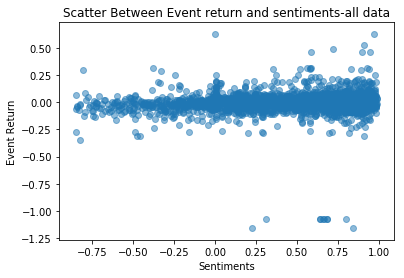

In [50]:
plt.scatter(data_df['sentiment_lex'],data_df['eventRet'], alpha=0.5)
plt.title('Scatter Between Event return and sentiments-all data')
plt.ylabel('Event Return')
plt.xlabel('Sentiments')
plt.show()

# Strategy 

In [60]:
import backtrader as bt
import backtrader.indicators as btind
import backtrader.analyzers as btanalyzers

class Sentiment(bt.Indicator):
    lines = ('sentiment',)
    plotinfo = dict(
        plotymargin=0.5,
        plothlines=[0],
        plotyticks=[1.0, 0, -1.0])
    
    def next(self):
        self.sentiment = 0.0
        self.date = self.data.datetime
        date = bt.num2date(self.date[0]).date()
        prev_sentiment = self.sentiment        
        if date in date_sentiment:
            self.sentiment = date_sentiment[date]
        self.lines.sentiment[0] = self.sentiment


class SentimentStrat(bt.Strategy):
    params = (
        ('period', 15),
        ('printlog', True),
    )

    def log(self, txt, dt=None, doprint=False):
        ''' Logging function for this strategy'''
        if self.params.printlog or doprint:
            dt = dt or self.datas[0].datetime.date(0)
            print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close
        # Keep track of pending orders
        self.order = None
        self.buyprice = None
        self.buycomm = None
        self.sma = bt.indicators.SimpleMovingAverage(
            self.datas[0], period=self.params.period)
        self.date = self.data.datetime
        self.sentiment = None
        Sentiment(self.data)
        self.plotinfo.plot = False
        
        
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return
        
        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))
                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))
                
            self.bar_executed = len(self)     
            
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')
            
        # Write down: no pending order
        self.order = None
        
    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))
    
    ### Main Strat ###
    def next(self):        
        date = bt.num2date(self.date[0]).date()
        prev_sentiment = self.sentiment
        if date in date_sentiment:
            self.sentiment = date_sentiment[date]
        
        # Check if an order is pending. if yes, we cannot send a 2nd one
        if self.order:
            return       
        # If not in the market and previous sentiment not none
        if not self.position and prev_sentiment:
            # buy if current close more than sma AND sentiment increased by >= 0.5
            if self.dataclose[0] > self.sma[0] and self.sentiment - prev_sentiment >= 0.5:
                self.log('Previous Sentiment %.2f, New Sentiment %.2f BUY CREATE, %.2f' % (prev_sentiment, self.sentiment, self.dataclose[0]))                
                self.order = self.buy()
                
        # Already in the market and previous sentiment not none
        elif prev_sentiment:
            # sell if current close less than sma AND sentiment decreased by >= 0.5
            if self.dataclose[0] < self.sma[0] and self.sentiment - prev_sentiment <= -0.5:
                self.log('Previous Sentiment %.2f, New Sentiment %.2f SELL CREATE, %.2f' % (prev_sentiment, self.sentiment, self.dataclose[0]))                
                self.order = self.sell()

    def stop(self):
        self.log('(MA Period %2d) Ending Value %.2f' %
                 (self.params.period, self.broker.getvalue()), doprint=True)   



In [61]:
def run_strategy(ticker, start, end):
    print(ticker)    
    ticker = yf.Ticker(ticker)
    df_ticker = ticker.history(start = start, end = end)
    
    cerebro = bt.Cerebro()
    # Add the data
    cerebro.addstrategy(SentimentStrat)        
    data = bt.feeds.PandasData(dataname=df_ticker)
    cerebro.adddata(data)    
    start = 100000.0
    cerebro.broker.setcash(start)   
    cerebro.addsizer(bt.sizers.FixedSize, stake=100)
    print('Starting Portfolio Value: %.2f' % start)    
    plt.rcParams['figure.figsize']=[10,6]
    plt.rcParams["font.size"]="12"
    cerebro.run() 
    cerebro.plot(volume=False, iplot=True, plotname= ticker)
    end = cerebro.broker.getvalue()
    print('Start Portfolio value: %.2f\nFinal Portfolio Value: %.2f\nProfit: %.2f\n' \
          % (start, end, end - start))
    return float(df_ticker['Close'][0]), (end - start)

First running the strategy for google

GOOG
Starting Portfolio Value: 100000.00
2012-04-12, Previous Sentiment 0.24, New Sentiment 0.80 BUY CREATE, 324.29
2012-04-13, BUY EXECUTED, Price: 322.57, Cost: 32257.00, Comm 0.00
2012-10-18, Previous Sentiment 0.98, New Sentiment 0.08 SELL CREATE, 346.20
2012-10-19, SELL EXECUTED, Price: 351.47, Cost: 32257.00, Comm 0.00
2012-10-19, OPERATION PROFIT, GROSS 2890.00, NET 2890.00
2013-01-10, Previous Sentiment 0.08, New Sentiment 0.80 BUY CREATE, 369.36
2013-01-11, BUY EXECUTED, Price: 369.61, Cost: 36961.00, Comm 0.00
2014-07-17, Previous Sentiment 0.73, New Sentiment -0.22 SELL CREATE, 572.16
2014-07-18, SELL EXECUTED, Price: 591.38, Cost: 36961.00, Comm 0.00
2014-07-18, OPERATION PROFIT, GROSS 22177.00, NET 22177.00
2014-07-18, Previous Sentiment -0.22, New Sentiment 0.77 BUY CREATE, 593.45
2014-07-21, BUY EXECUTED, Price: 590.13, Cost: 59013.00, Comm 0.00
2014-09-12, Previous Sentiment 0.66, New Sentiment -0.05 SELL CREATE, 574.04
2014-09-15, SELL EXECUTED, Price: 571.37, Cost: 59

<IPython.core.display.Javascript object>


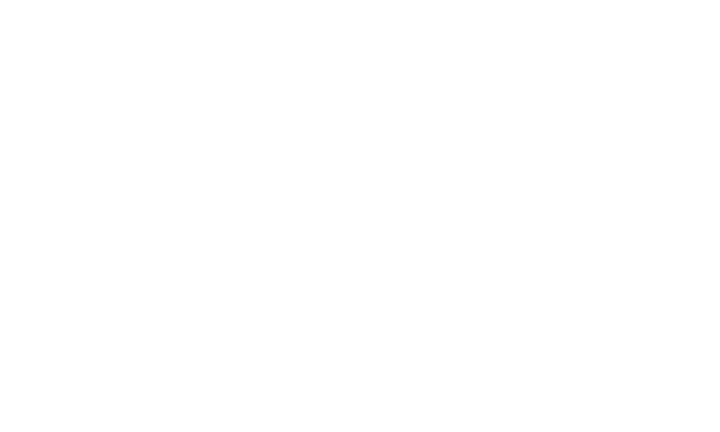

Start Portfolio value: 100000.00
Final Portfolio Value: 149719.00
Profit: 49719.00



(331.46, 49719.0)

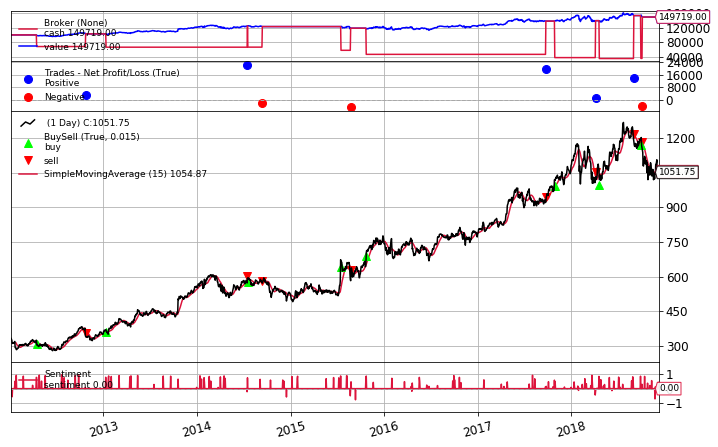

In [62]:
ticker = 'GOOG'
date_sentiment=data_df[data_df['ticker'].isin([ticker])]
date_sentiment=date_sentiment[['date','sentiment_lex']]
date_sentiment['date']=pd.to_datetime(date_sentiment['date'], format='%Y-%m-%d').dt.date
date_sentiment=date_sentiment.set_index('date')['sentiment_lex']
date_sentiment=date_sentiment.to_dict()
run_strategy(ticker, start = '2012-01-01', end = '2018-12-12')

Now we choose one of the days on which buy was triggered and we look at the news on that data and previous day.

In [63]:
GOOG_ticker= data_df[data_df['ticker'].isin([ticker])]
New= list(GOOG_ticker[GOOG_ticker['date'] ==  '2015-07-17']['headline'])
Old= list(GOOG_ticker[GOOG_ticker['date'] ==  '2015-07-16']['headline'])
print("Current News:",New,"\n\n","Previous News:", Old)

Current News: ["Axiom Securities has upgraded Google (GOOG +13.4%, GOOGL +14.8%) to Buy following the company's Q2 beat and investor-pleasing comments about spending discipline, potential capital returns, and YouTube/mobile growth. MKM has launched coverage at Buy, and plenty of other firms have hiked their targets. Google's market cap is now above $450B."] 

 Previous News: ["While Google's (GOOG, GOOGL) Q2 revenue slightly missed estimates when factoring traffic acquisitions costs (TAC), its ex-TAC revenue of $14.35B was slightly above a $14.3B consensus. The reason: TAC fell to 21% of ad revenue from Q1's 22% and Q2 2014's 23%. That also, of course, helped EPS beat estimates.", 'Google (NASDAQ:GOOG): Q2 EPS of $6.99 beats by $0.28.']


Clearly the News on the current day has positive sentiment as compared to the news at the previous day causing the buy to be triggered. Now, we run the strategy for Facebook.

FB
Starting Portfolio Value: 100000.00
2012-11-14, Previous Sentiment -0.82, New Sentiment 0.71 BUY CREATE, 22.36
2012-11-15, BUY EXECUTED, Price: 22.34, Cost: 2234.00, Comm 0.00
2013-03-13, Previous Sentiment 0.95, New Sentiment -0.25 SELL CREATE, 27.08
2013-03-14, SELL EXECUTED, Price: 27.10, Cost: 2234.00, Comm 0.00
2013-03-14, OPERATION PROFIT, GROSS 476.00, NET 476.00
2013-04-10, Previous Sentiment -0.25, New Sentiment 0.94 BUY CREATE, 27.57
2013-04-11, BUY EXECUTED, Price: 27.48, Cost: 2748.00, Comm 0.00
2013-11-18, Previous Sentiment 0.98, New Sentiment 0.40 SELL CREATE, 45.83
2013-11-19, SELL EXECUTED, Price: 46.26, Cost: 2748.00, Comm 0.00
2013-11-19, OPERATION PROFIT, GROSS 1878.00, NET 1878.00
2014-01-30, Previous Sentiment 0.01, New Sentiment 0.82 BUY CREATE, 61.08
2014-01-31, BUY EXECUTED, Price: 60.47, Cost: 6047.00, Comm 0.00
2014-12-16, Previous Sentiment 0.68, New Sentiment -0.39 SELL CREATE, 74.69
2014-12-17, SELL EXECUTED, Price: 75.01, Cost: 6047.00, Comm 0.00
2014-

<IPython.core.display.Javascript object>


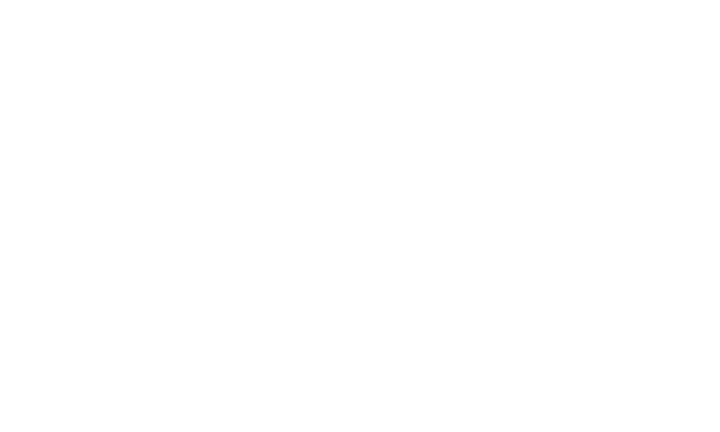

Start Portfolio value: 100000.00
Final Portfolio Value: 108041.00
Profit: 8041.00



(38.23, 8041.0)

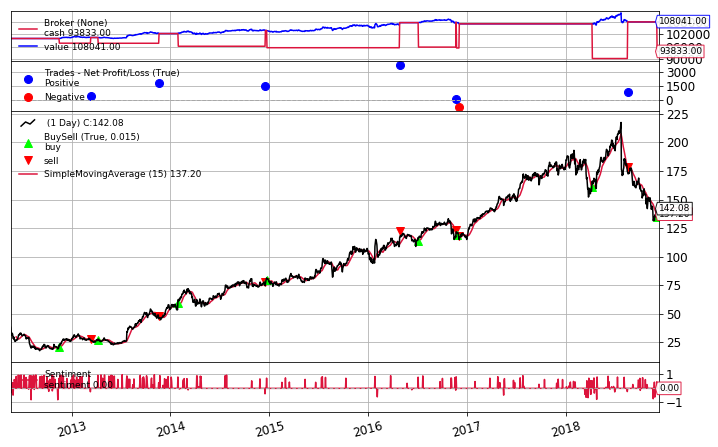

In [64]:
ticker = 'FB'
date_sentiment=data_df[data_df['ticker'].isin([ticker])]
date_sentiment=date_sentiment[['date','sentiment_lex']]
date_sentiment['date']=pd.to_datetime(date_sentiment['date'], format='%Y-%m-%d').dt.date
date_sentiment=date_sentiment.set_index('date')['sentiment_lex']
date_sentiment=date_sentiment.to_dict()
run_strategy(ticker, start = '2012-01-01', end = '2018-12-12')

Top Panel : The CashValue shows overall profit of 8041.00.

Second Panel : A Trade Observer shows that six out of 7 actions are profitable. 

Third Panel : A BuySell observer shows that in general the buy action takes place when the stock price is increasing and the sell action takes place when the stock price has started declining.   

Forth Panel : It shows high number of positive sentiment for the FB around 2013 and 2014 period.

AAPL
Starting Portfolio Value: 100000.00
2013-12-13, Previous Sentiment -0.38, New Sentiment 0.86 BUY CREATE, 70.91
2013-12-16, BUY EXECUTED, Price: 70.99, Cost: 7099.00, Comm 0.00
2014-09-25, Previous Sentiment 0.78, New Sentiment 0.04 SELL CREATE, 89.08
2014-09-26, SELL EXECUTED, Price: 89.68, Cost: 7099.00, Comm 0.00
2014-09-26, OPERATION PROFIT, GROSS 1869.00, NET 1869.00
2014-10-21, Previous Sentiment 0.14, New Sentiment 0.68 BUY CREATE, 93.27
2014-10-22, BUY EXECUTED, Price: 93.61, Cost: 9361.00, Comm 0.00
2015-06-11, Previous Sentiment 0.48, New Sentiment -0.42 SELL CREATE, 118.51
2015-06-12, SELL EXECUTED, Price: 118.14, Cost: 9361.00, Comm 0.00
2015-06-12, OPERATION PROFIT, GROSS 2453.00, NET 2453.00
2015-09-14, Previous Sentiment 0.35, New Sentiment 0.95 BUY CREATE, 106.75
2015-09-15, BUY EXECUTED, Price: 107.33, Cost: 10733.00, Comm 0.00
2015-12-14, Previous Sentiment 0.24, New Sentiment -0.62 SELL CREATE, 104.58
2015-12-15, SELL EXECUTED, Price: 104.08, Cost: 10733.00, Comm

<IPython.core.display.Javascript object>


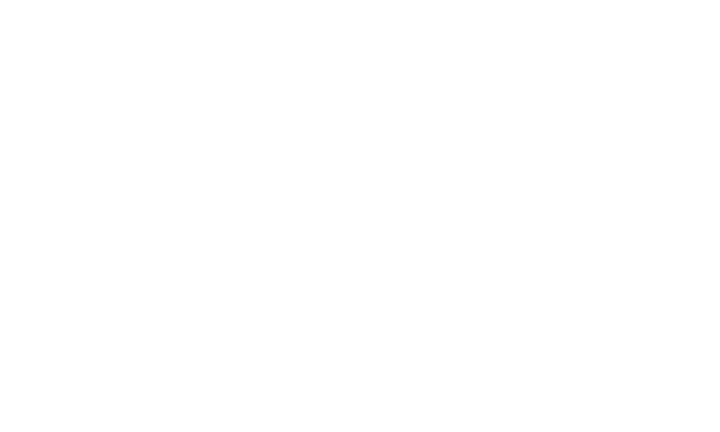

Start Portfolio value: 100000.00
Final Portfolio Value: 103735.00
Profit: 3735.00

MSFT
Starting Portfolio Value: 100000.00
2012-03-08, Previous Sentiment -0.50, New Sentiment 0.92 BUY CREATE, 26.43
2012-03-09, BUY EXECUTED, Price: 26.51, Cost: 2651.00, Comm 0.00
2012-04-04, Previous Sentiment 0.87, New Sentiment -0.42 SELL CREATE, 25.77
2012-04-05, SELL EXECUTED, Price: 25.72, Cost: 2651.00, Comm 0.00
2012-04-05, OPERATION PROFIT, GROSS -79.00, NET -79.00
2012-06-19, Previous Sentiment 0.15, New Sentiment 0.88 BUY CREATE, 25.52
2012-06-20, BUY EXECUTED, Price: 25.71, Cost: 2571.00, Comm 0.00
2012-07-12, Previous Sentiment 0.68, New Sentiment -0.65 SELL CREATE, 23.80
2012-07-13, SELL EXECUTED, Price: 23.90, Cost: 2571.00, Comm 0.00
2012-07-13, OPERATION PROFIT, GROSS -181.00, NET -181.00
2012-11-01, Previous Sentiment -0.69, New Sentiment 0.59 BUY CREATE, 24.70
2012-11-02, BUY EXECUTED, Price: 24.76, Cost: 2476.00, Comm 0.00
2012-11-13, Previous Sentiment 0.96, New Sentiment 0.13 SELL 

2013-02-21, Previous Sentiment 0.87, New Sentiment 0.04 SELL CREATE, 35.16
2013-02-22, SELL EXECUTED, Price: 35.72, Cost: 3382.00, Comm 0.00
2013-02-22, OPERATION PROFIT, GROSS 190.00, NET 190.00
2013-03-25, Previous Sentiment 0.32, New Sentiment 0.87 BUY CREATE, 37.53
2013-03-26, BUY EXECUTED, Price: 37.98, Cost: 3798.00, Comm 0.00
2013-09-12, Previous Sentiment 0.94, New Sentiment 0.28 SELL CREATE, 164.93
2013-09-13, SELL EXECUTED, Price: 162.77, Cost: 3798.00, Comm 0.00
2013-09-13, OPERATION PROFIT, GROSS 12479.00, NET 12479.00
2014-02-24, Previous Sentiment -0.27, New Sentiment 0.80 BUY CREATE, 217.65
2014-02-25, BUY EXECUTED, Price: 230.00, Cost: 23000.00, Comm 0.00
2014-03-18, Previous Sentiment 0.80, New Sentiment 0.11 SELL CREATE, 240.04
2014-03-19, SELL EXECUTED, Price: 241.39, Cost: 23000.00, Comm 0.00
2014-03-19, OPERATION PROFIT, GROSS 1139.00, NET 1139.00
2014-06-05, Previous Sentiment -0.08, New Sentiment 0.65 BUY CREATE, 206.90
2014-06-06, BUY EXECUTED, Price: 209.75, Co

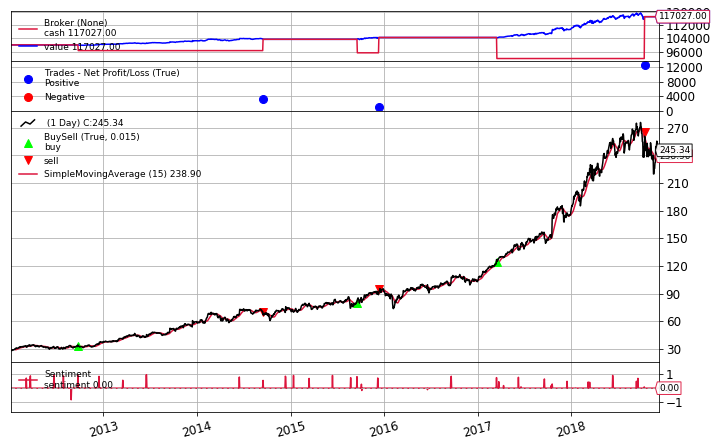

In [65]:
results_tickers = {}
for ticker in tickers:    
    date_sentiment=data_df[data_df['ticker'].isin([ticker])]
    date_sentiment=date_sentiment[['date','sentiment_lex']]
    date_sentiment['date']=pd.to_datetime(date_sentiment['date'], format='%Y-%m-%d').dt.date
    date_sentiment=date_sentiment.set_index('date')['sentiment_lex']
    date_sentiment=date_sentiment.to_dict()
    results_tickers[ticker] = run_strategy(ticker, start = '2012-01-01', end = '2018-12-12')

In [66]:
pd.DataFrame.from_dict(results_tickers).set_index([pd.Index(["PerUnitStartPrice", 'StrategyProfit'])])

,AAPL,MSFT,AMZN,GOOG,FB,WMT,JPM,TSLA,NFLX,ADBE
PerUnitStartPrice,50.86,21.96,179.03,331.46,38.23,48.78,27.31,28.08,10.32,28.57
StrategyProfit,3735.00,4067.00,75377.00,49719.00,8041.00,1152.00,2014.00,15755.00,25181.00,17027.00
